# Analysis of single-cell RNA-seq data for Mouse Retinal Development

This Python notebook performs an analysis of the cell types and their marker genes on provided GSE118614_Smart dataset.

## Basic QC


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

  verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white')


 the file that will store the analysis results

In [3]:
results_file = 'swrite/retsmart.h5ad'

Reading the data

In [4]:
adata = sc.read_10x_mtx(
    'sdata',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


# adata=sc.read_mtx('sdata/GSE118614_Smart_aggregate.mtx')
genes= pd.read_csv('sdata/GSE118614_Smart_genes.tsv', header=0, sep='\t')


cells = pd.read_csv('sdata/GSE118614_Smart_cells.tsv', header=0, sep='\t')
adata.obs['CellType']=cells['CellType'].values
adata.obs['Age']=cells['Age'].values
adata.obs['Plate']=cells['Plate'].values

print(adata)                         

... reading from cache file cache\sdata-matrix.h5ad
AnnData object with n_obs × n_vars = 747 × 28446
    obs: 'CellType', 'Age', 'Plate'
    var: 'gene_ids'


Making variable and gene names unique. 

In [5]:
adata.var_names_make_unique()  
adata.obs_names_make_unique() 


 Let’s assemble some information about mitochondrial genes, which are important for quality control. Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017): High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016),  possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
 With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

 A violin plot of some of the computed quality measures: the number of genes expressed in the count matrix, the total counts per cell, the percentage of counts in mitochondrial genes. n_genes_by_counts is the number of unique genes expressed in each cells, and total_counts is the total number of genes expressed in each cell.

... storing 'CellType' as categorical
... storing 'Age' as categorical
... storing 'Plate' as categorical


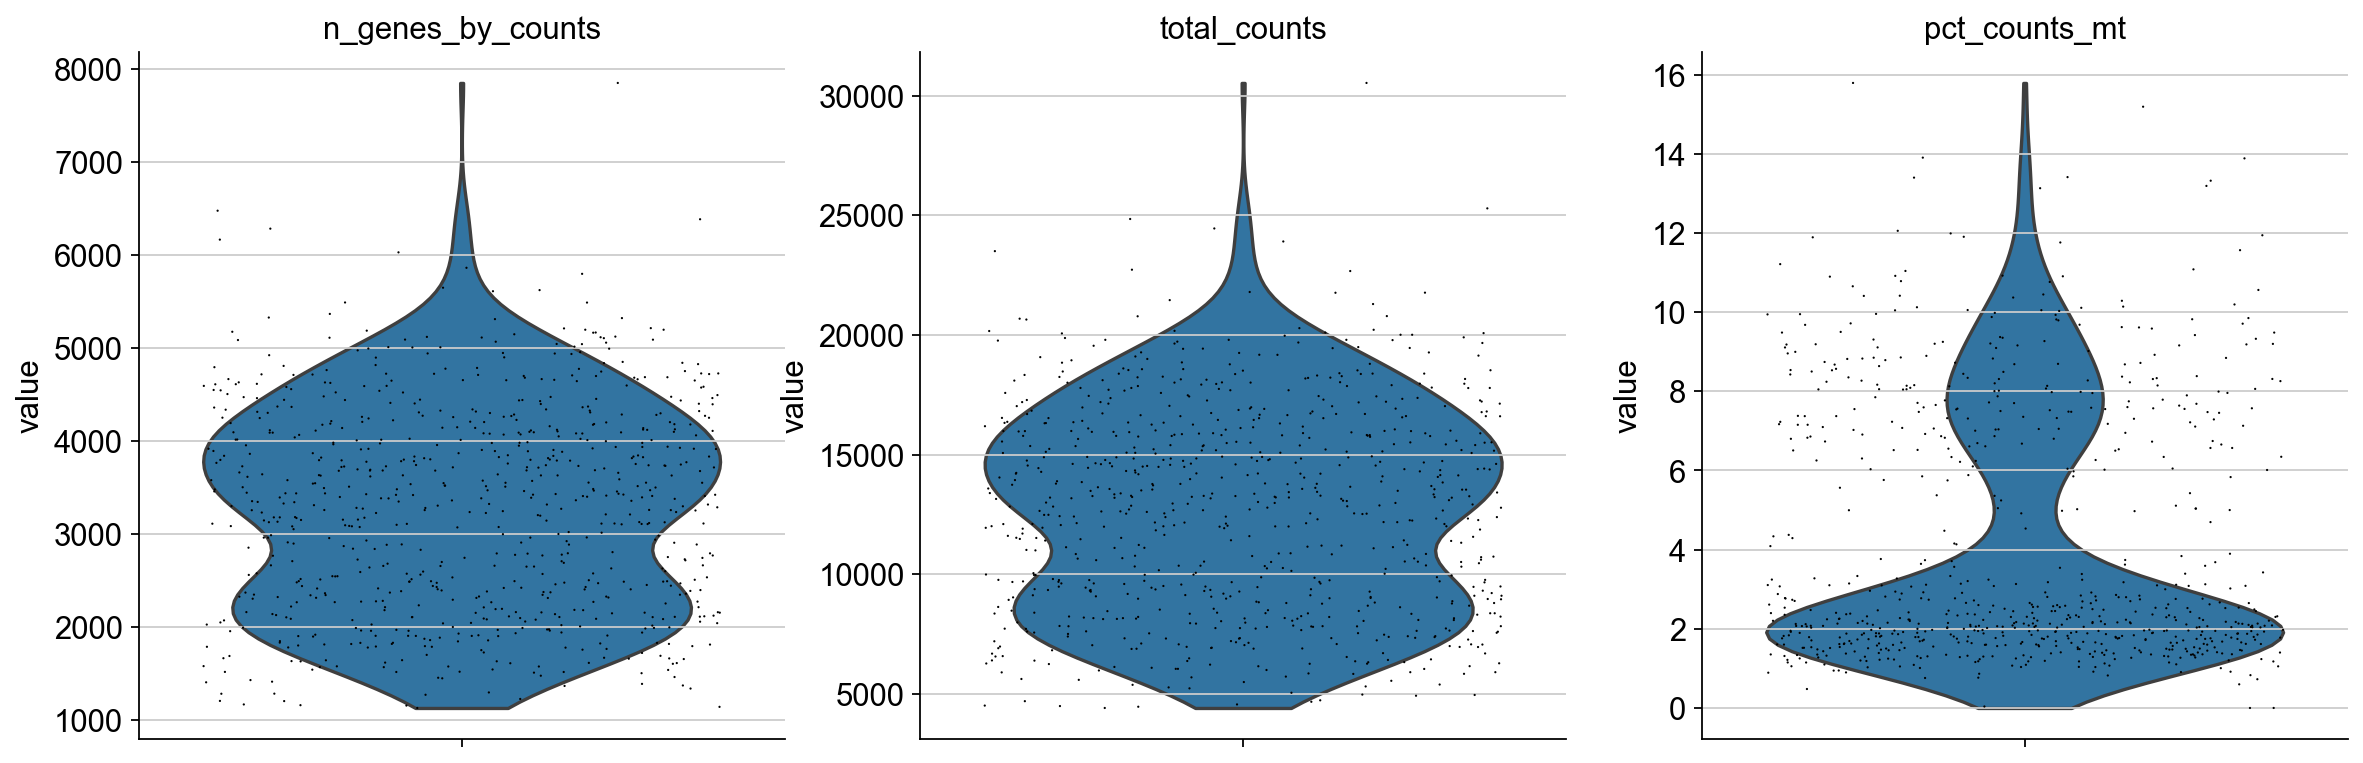

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

These analysis indicate that  we can filter out cells with more that 7000 genes by count. we can also plot a histigram of a single variable. It seems also typical to filter out cells with more that 5% of mitocondrial genes expressed. the following plot approves that the cells with more than 5% mt genes expressed have less total counts that other cells.             


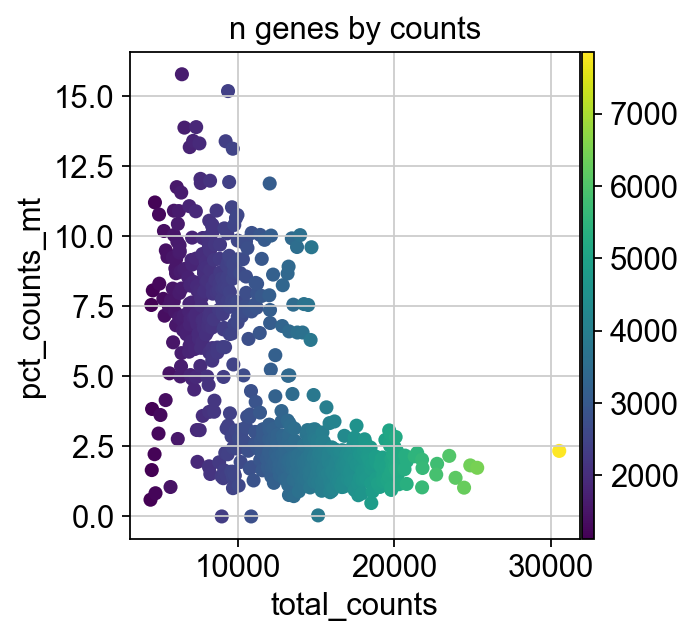

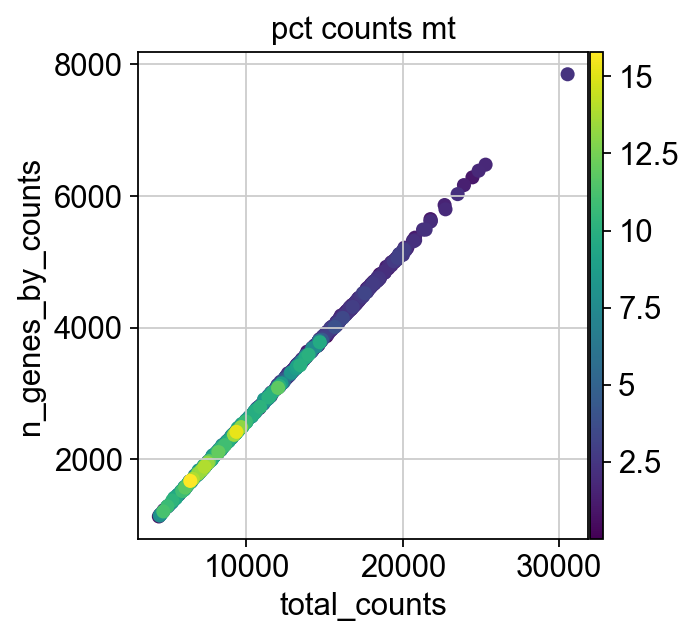

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

Simillar intuition can be obtained by plotting a histigram of a single variable 

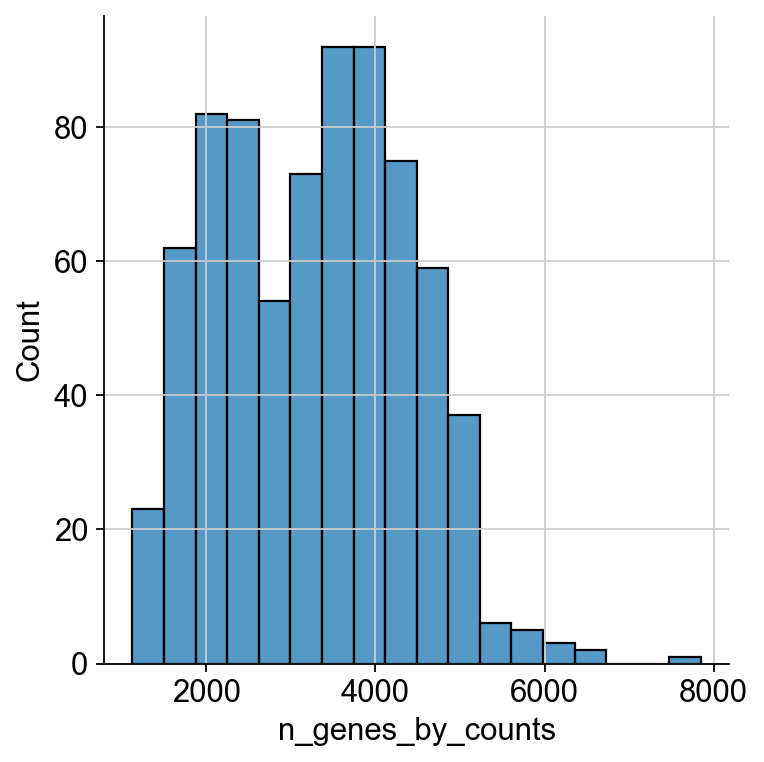

In [9]:
sns.displot(adata.obs['n_genes_by_counts'])


## Basic filtering:

Remove cells that have too many mitochondrial genes expressed or too many total counts:

In [10]:
adata = adata[adata.obs.pct_counts_mt < 10,:]
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=0.1)
adata.raw = adata

Trying to set attribute `.obs` of view, copying.


filtered out 11889 genes that are detected in less than 3 cells


Trying to set attribute `.var` of view, copying.


filtered out 234 genes that are detected in less than 0.1 counts


Normalize total counts to 10k. There was elaborate discussion on W20 workshop if this normalization step is of any help. 

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


 Logarithmize the data:  log(X+1)

In [12]:
sc.pp.log1p(adata) 

## Highly Variable Genes

Identify highly-variable genes.

filter to only include highly variable genes. 

## Principal component analysis


Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data. 

Scale to unit variance for PCA, and clip values exceeding variance 10.

In [13]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Reduce the dimensionality of the data with PCA

In [14]:
sc.pp.pca(adata)


computing PCA
    with n_comps=50
    finished (0:00:01)


Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or UMAP sc.tl.umap(). Often, a rough estimate of the number of PCs does fine. 

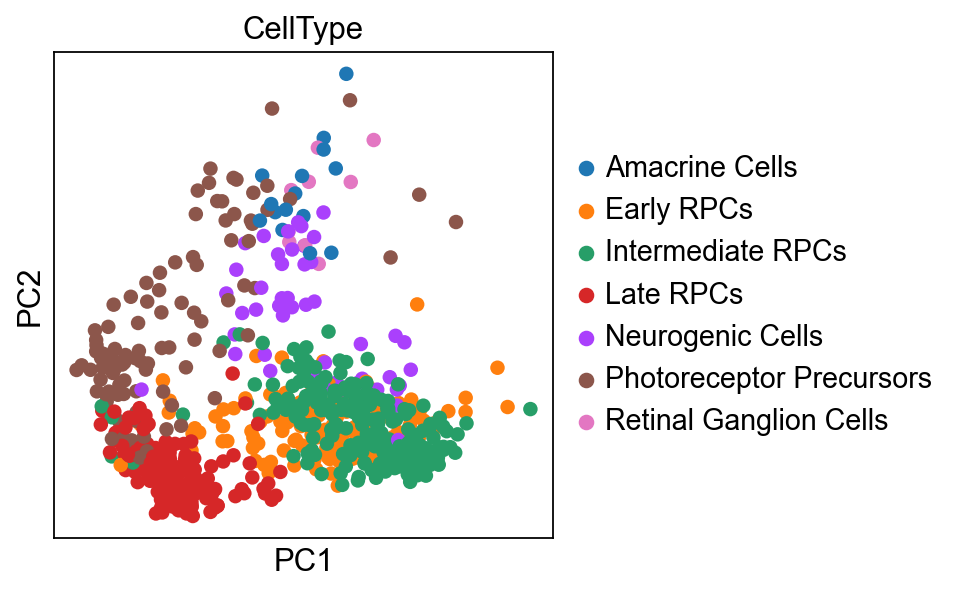

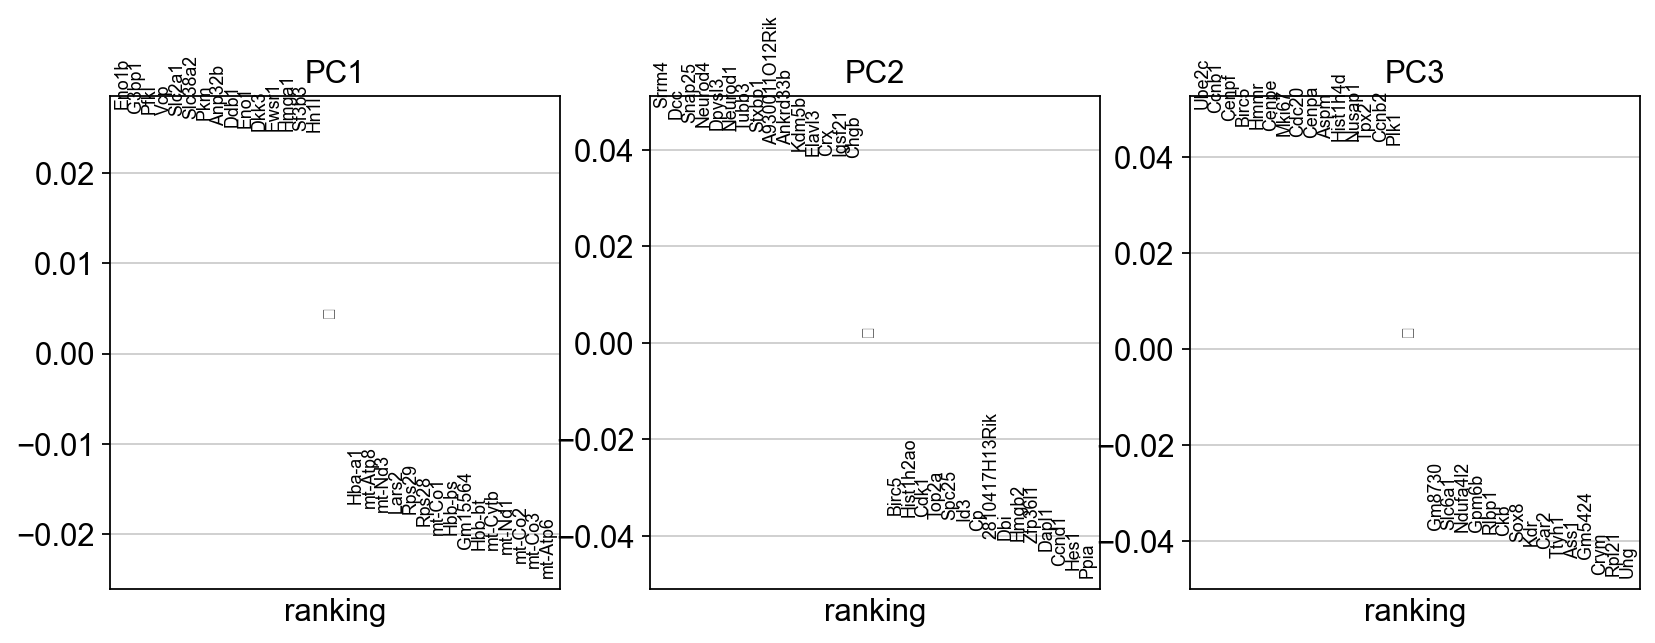

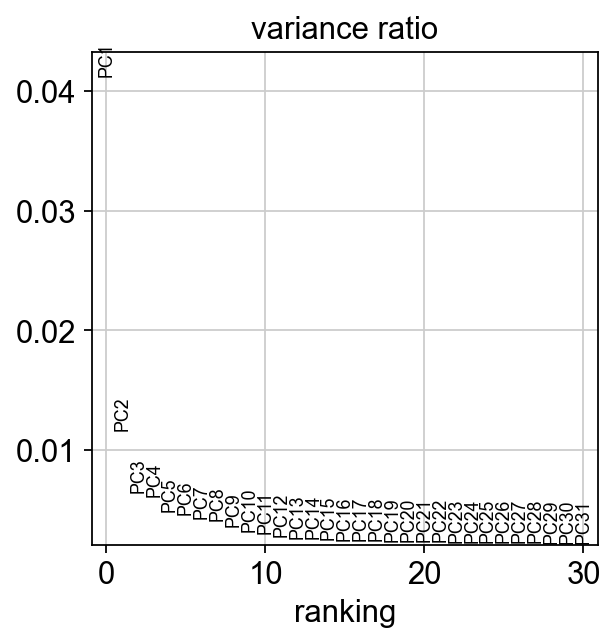

In [15]:
sc.pl.pca_overview(adata, color='CellType')

scatter in the PCA coordinates, won't be used later on, only for visualization. 

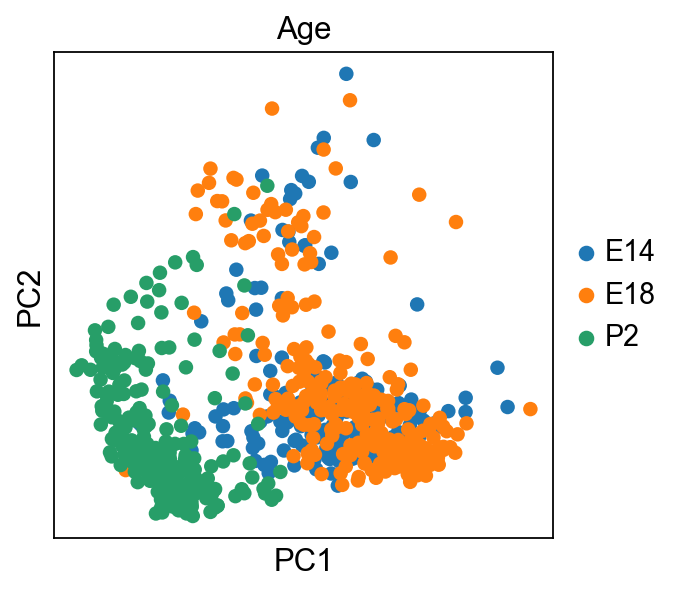

In [16]:
sc.pl.pca(adata, color='Age')


## Compute the neighborhood graph


Next we compute the neighborhood graph of cells using the PCA representation of the data matrix. Number of principal components used here (n_pcs=18), is obtained by analyzing pca_variance_ratio output with PCA_Elbow_fit function introduced in W20 workshop. 

In [17]:
sc.pp.neighbors(adata, n_neighbors=17, n_pcs=33)


computing neighbors
    using 'X_pca' with n_pcs = 33
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


## Cluster the neighborhood graph

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks. Here we demonstrate clustering using Louvain clustering, which is a popular method for clustering single-cell RNA-seq data. 

Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [18]:
sc.tl.louvain(adata, resolution=0.8, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


A plot of the clusters is shown below:

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


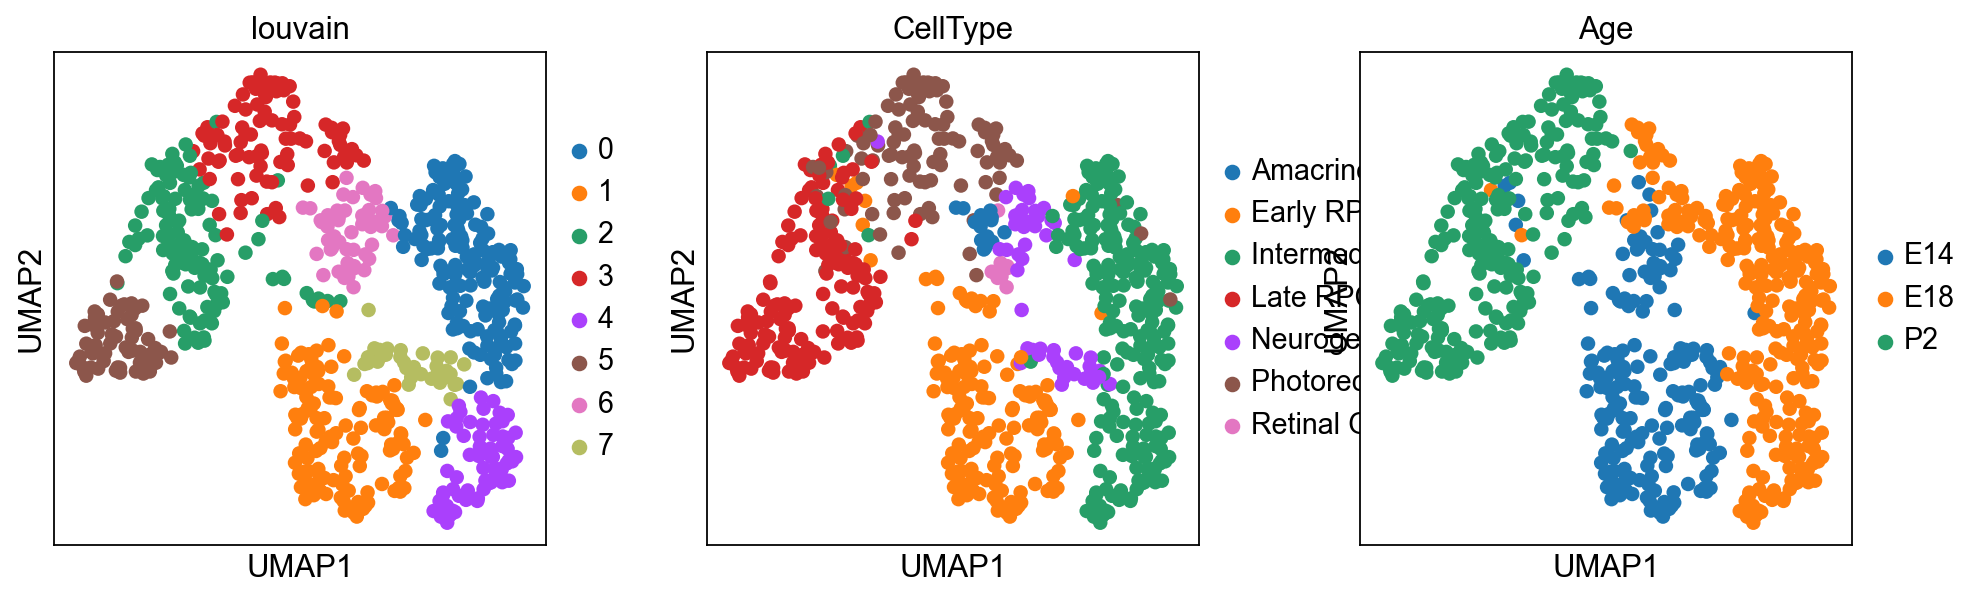

The Rand index is 0.62


In [19]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color= ['louvain', 'CellType', 'Age'])
rand_index = adjusted_rand_score(labels_true = adata.obs['CellType'], labels_pred = adata.obs['louvain'])

print('The Rand index is', round(rand_index, 2))


## Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Here we compute ranking for differential genes in each cluster using wilcoxon rank-sum. 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellType']`


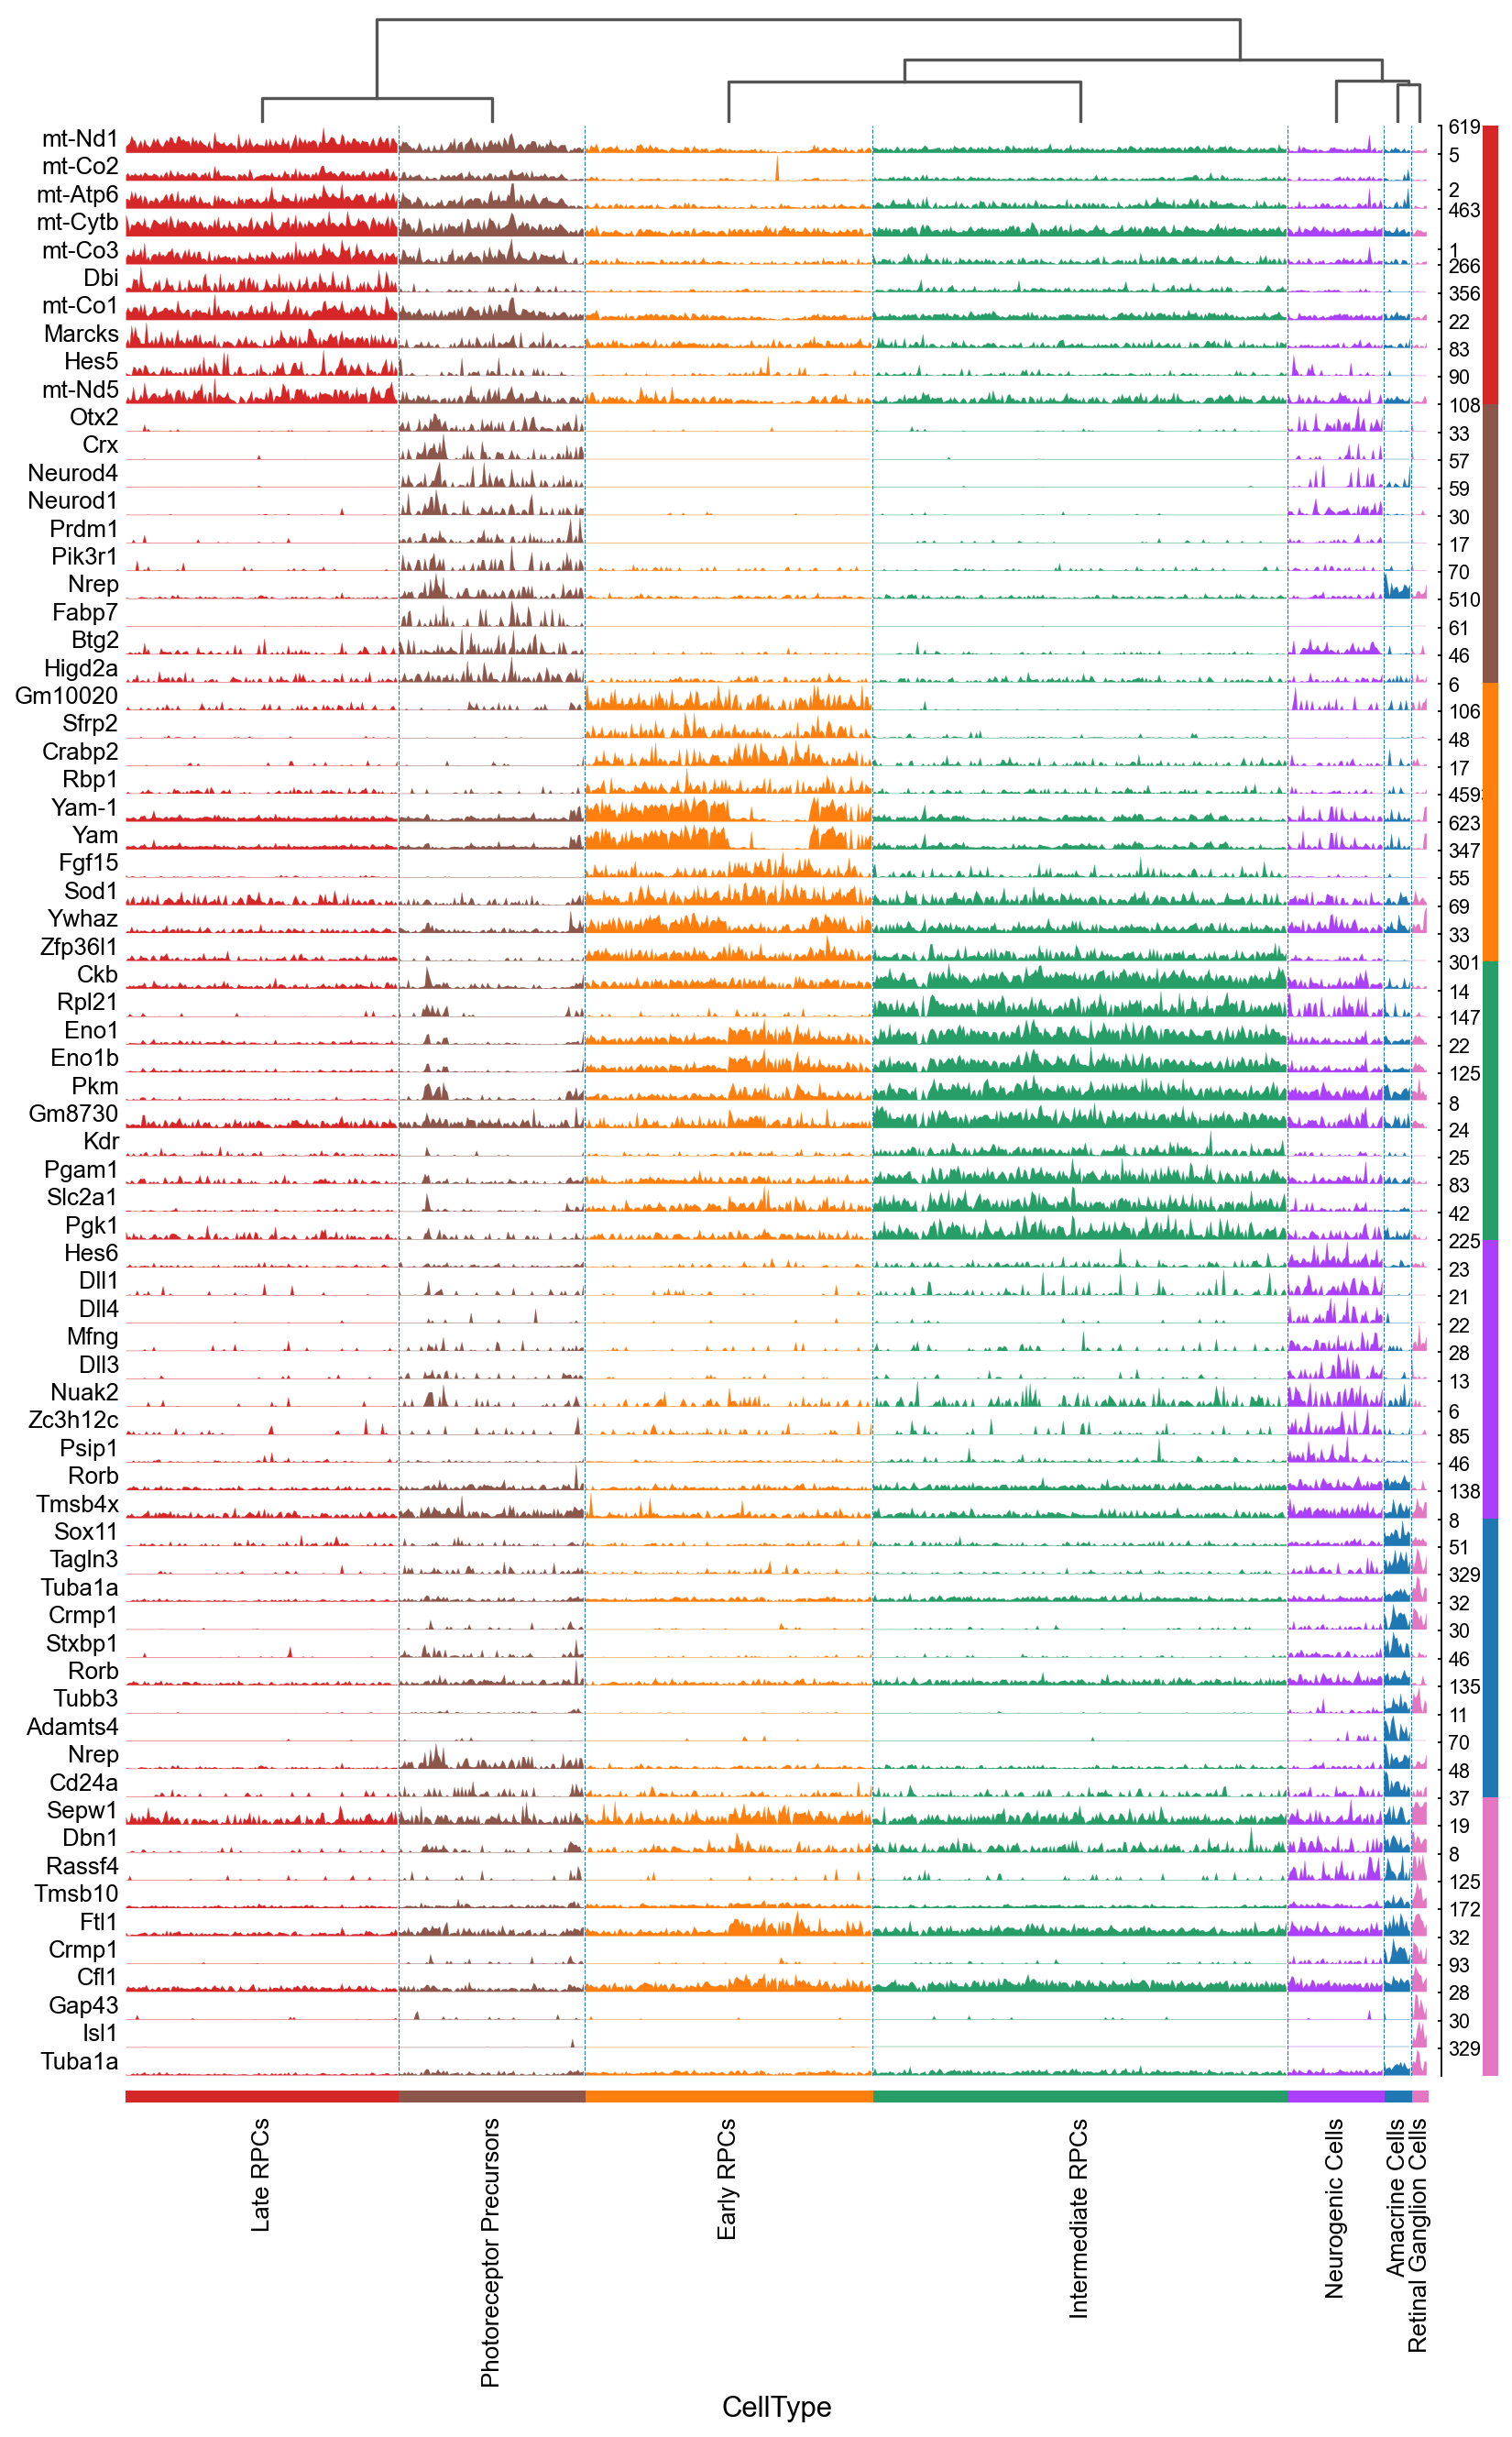

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


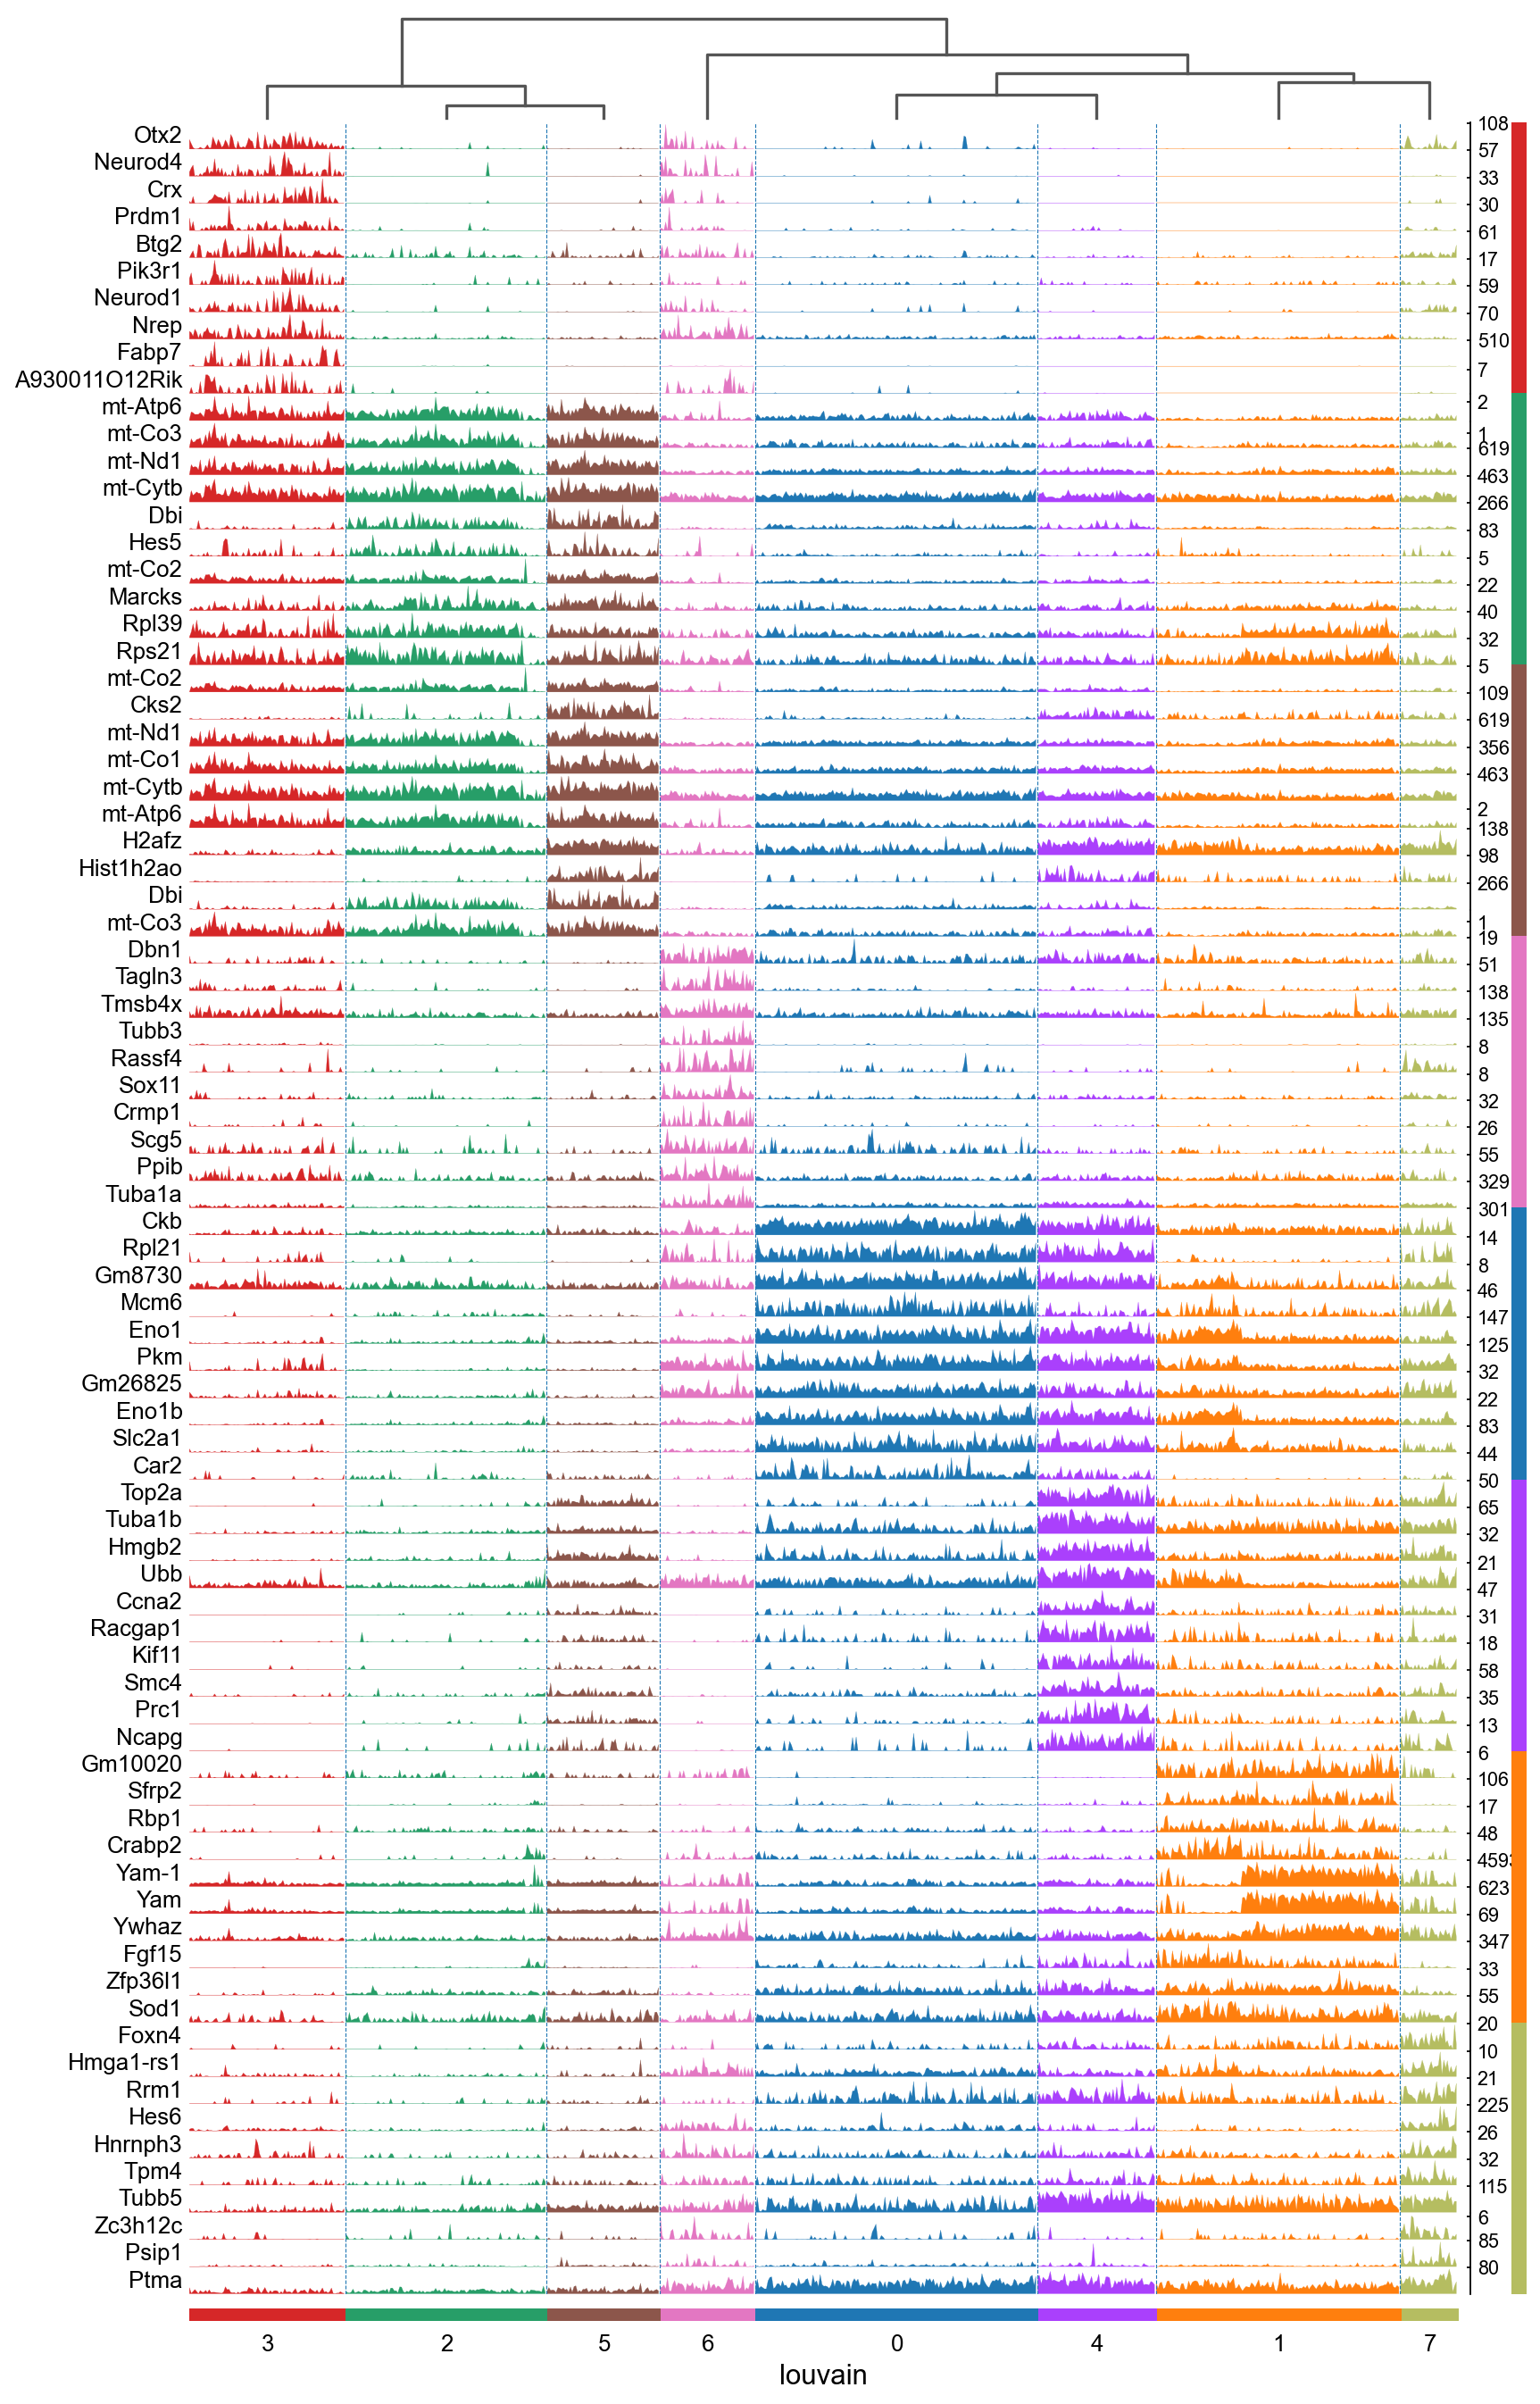

In [20]:
sc.tl.rank_genes_groups(adata, groupby='CellType', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='CellType') # plot the result



sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='louvain') # plot the result


Marker genes are usually provided by previous knowledge of cell types and their associated gene markers to visualize how different clusters are related to these known genes. Here, I used some of the genes named in "Genomic Analysis of Mouse Retinal Development" paper by Seth Blackshaw, et. al. This helps visualize what genes are expressed in each cluster. 

In [21]:
marker_genes = {
'Photo. Precurs.': ['Neurod1', 'Opn1sw', 'Crx'], 
'Neurogenetic': ['Neurog2','Hes6', 'Olig2'],
'RGCs': ['Atoh7','Elavl4', 'Rbpms'],
'Amacrine Cells': ['Sox4','Pax6','3110035E14Rik'],
'Late RPCs': ['Hes5','Id1','Id2','Id3'],
'Int. RPCs': ['Heyl','Sox8','Rlbp1'],
'Early RPCs': ['Fgf15','Ccnd2','Sfrp2']
}

Show the 5 top ranked genes per cluster 0, 1, ..., 12 in a dataframe.

In [22]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1        2              3        4          5       6  \
0      Ckb  Gm10020  mt-Atp6           Otx2    Top2a     mt-Co2    Dbn1   
1    Rpl21    Sfrp2   mt-Co3        Neurod4   Tuba1b       Cks2  Tagln3   
2   Gm8730     Rbp1   mt-Nd1            Crx    Hmgb2     mt-Nd1  Tmsb4x   
3     Mcm6   Crabp2  mt-Cytb          Prdm1      Ubb     mt-Co1   Tubb3   
4     Eno1    Yam-1      Dbi           Btg2    Ccna2    mt-Cytb  Rassf4   
5      Pkm      Yam     Hes5         Pik3r1  Racgap1    mt-Atp6   Sox11   
6  Gm26825    Ywhaz   mt-Co2        Neurod1    Kif11      H2afz   Crmp1   
7    Eno1b    Fgf15   Marcks           Nrep     Smc4  Hist1h2ao    Scg5   
8   Slc2a1  Zfp36l1    Rpl39          Fabp7     Prc1        Dbi    Ppib   
9     Car2     Sod1    Rps21  A930011O12Rik    Ncapg     mt-Co3  Tuba1a   

           7  
0      Foxn4  
1  Hmga1-rs1  
2       Rrm1  
3       Hes6  
4    Hnrnph3  
5       Tpm4  
6      Tubb5  
7    Zc3h12c  
8      Psip1  
9       Ptma

Get a table with the scores and groups.

Compare a certain gene across groups

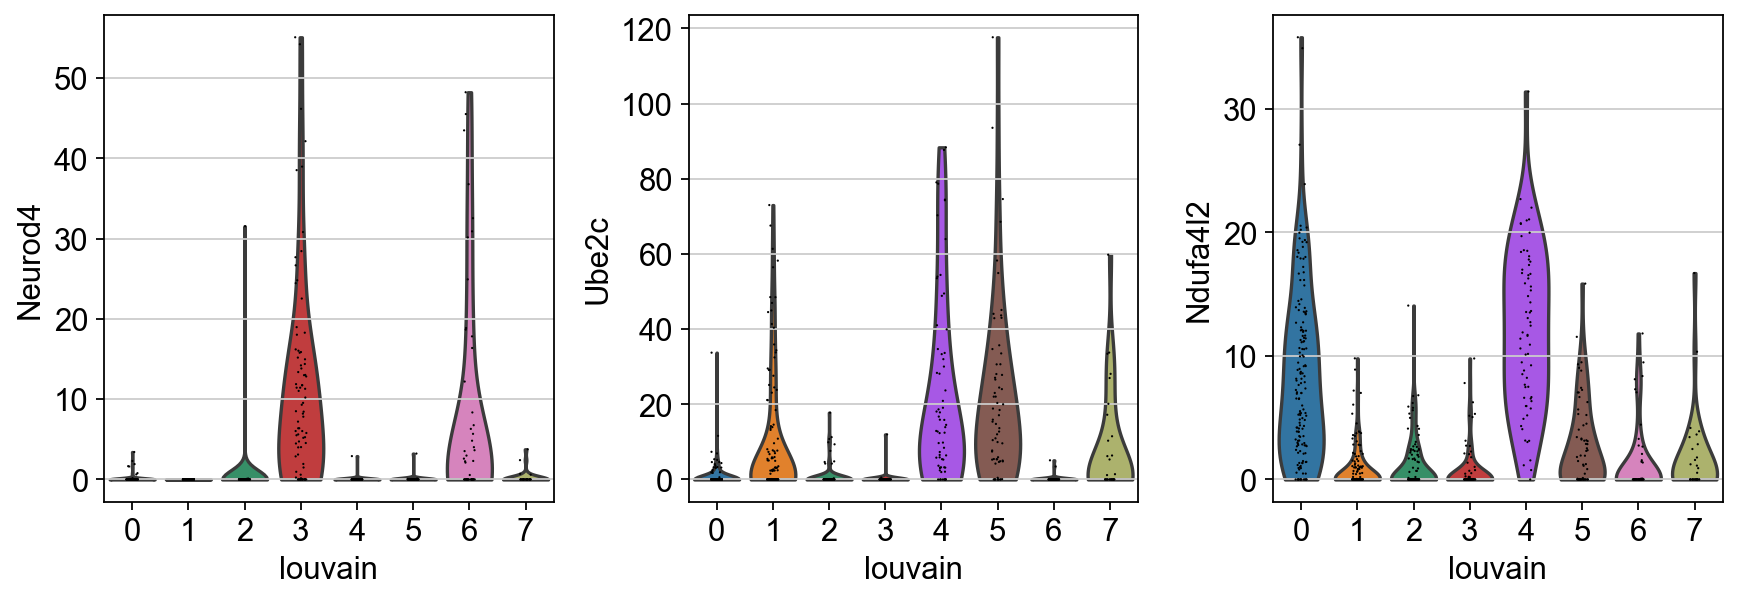

In [23]:
sc.pl.violin(adata, [ 'Neurod4', 'Ube2c','Ndufa4l2'], groupby='louvain')


Visualize the known marker genes in a matrixplot.

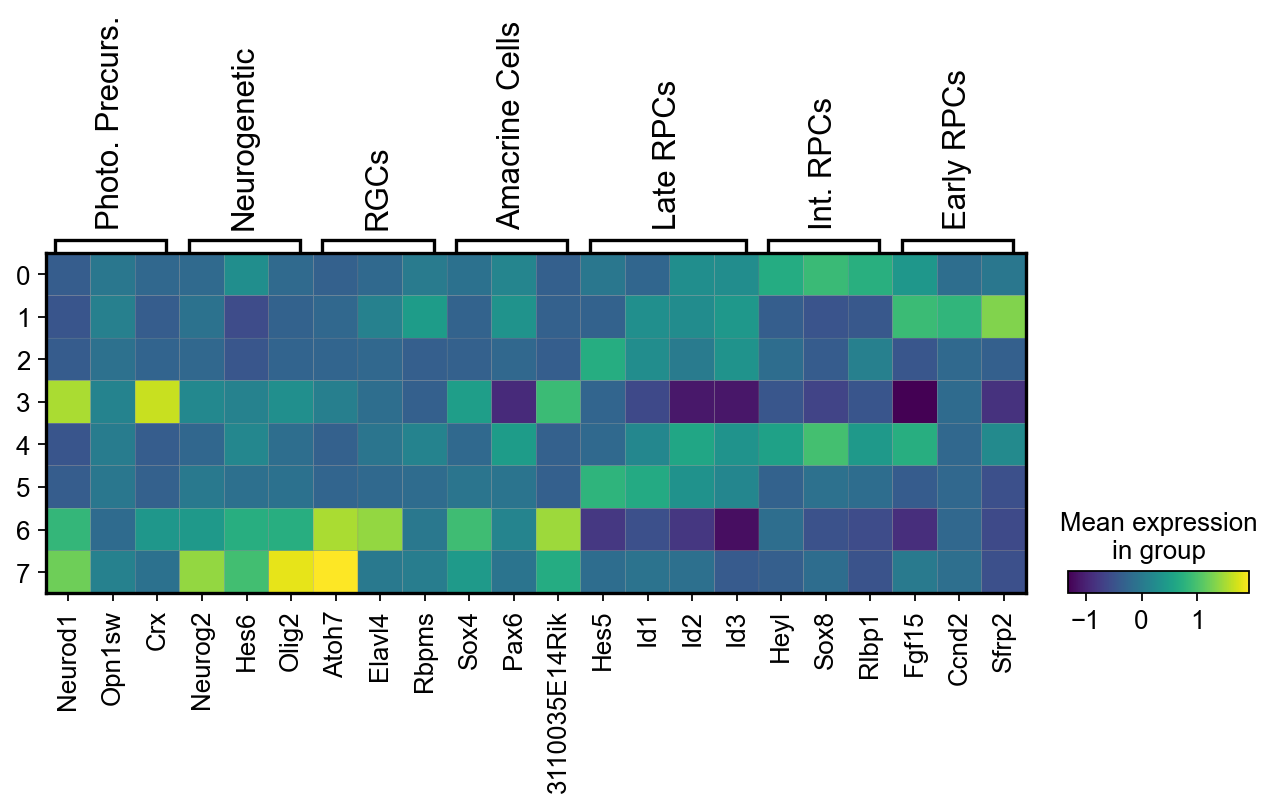

In [24]:
sc.pl.matrixplot(adata, marker_genes, groupby='louvain', use_raw=False)
